In [1]:
import numpy as np
from speclite import filters
from astropy import units as u

from matplotlib import pyplot as plt
from astropy.io import fits
import eazy.utils
from grizli import utils
import os
from astropy.utils.data import download_file
import msaexp.spectrum
from astropy.table import Table


Getting LRDs

In [2]:
# Load the complete table
table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.csv.gz"
tab = utils.read_catalog(download_file(table_url, cache=True), format='csv')
# Column descriptions
columns_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=True), format='csv')

# Set column metadata
for row in tab_columns:
    c = row['column']
    if row['unit'] != '--':
        tab[c].unit = row['unit']
    if row['format'] != '--':
        tab[c].format = row['format']
    if row['description'] != '--':
        tab[c].description = row['description']



In [3]:
combined_spectra_file = "dja_msaexp_emission_lines_v4.0.prism_spectra.fits"

if os.path.exists(combined_spectra_file):
    prism_spectra = utils.read_catalog(combined_spectra_file)
else:
    # Combined prism spectra in a single big table (595 Mb)
    prism_spectra = utils.read_catalog(
        download_file(
            f"https://s3.amazonaws.com/msaexp-nirspec/extractions/{combined_spectra_file}",
            cache=True
        ),
        format='fits',
    )

In [281]:
len(spec_file)

20

In [4]:
#Rustovok et al. 2025
# MSA_ID = np.array([68797,73488,42046,49140,1244,53501,51623, 58237, 38147,50052, 60935])
#setton et al. 2024
MSA_ID=[1045,68797,40579,4490,28074,4286,58018,13704,45924,4820,47509,1768,53501,31747,38108,13329,12402,38147,27830,73488]

spec_file=["macsj0647-v4_prism-clear_1433_1045.spec.fits",
              'jades-gdn-v4_prism-clear_1181_68797.spec.fits',
              'rubies-uds1-v4_prism-clear_4233_40579.spec.fits',
              'jades-gds-w03-v4_prism-clear_1212_537.spec.fits',
              'jades-gdn2-v4_prism-clear_1181_28074.spec.fits',
              'uncover-v4_prism-clear_2561_4286.spec.fits',
              'cosmos-transients-v4_prism-clear_6585_58018.spec.fits',
              'gds-deep-v4_prism-clear_1210_13704.spec.fits',
              'uncover-62-v4_prism-clear_2561_58453.spec.fits',
              'gds-barrufet-s67-v4_prism-clear_2198_4820.spec.fits',
              "rubies-uds3-v4_prism-clear_4233_47509.spec.fits",
              'ceers-ddt-v4_prism-clear_2750_1768.spec.fits',
              'jades-gdn-v4_prism-clear_1181_53501.spec.fits',
              'rubies-uds1-v4_prism-clear_4233_31747.spec.fits',
              'uncover-v4_prism-clear_2561_38108.spec.fits',
              'jades-gds-wide-v4_prism-clear_1180_13329.spec.fits',
              'jades-gdn09-v4_prism-clear_1181_73488.spec.fits',
              'jades-gds-wide-v4_prism-clear_1180_12402.spec.fits',
              'jades-gdn-v4_prism-clear_1181_38147.spec.fits',
              'jades-gdn10-v4_prism-clear_1181_27830.spec.fits']
              

In [5]:
FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"
is_prism = tab['grating'] == 'PRISM'
has_z_spec = tab['z_best'] >= 0
good_grade = tab['grade'] >= 3

prism_z = is_prism & has_z_spec & good_grade
LRD_MSAID = np.isin(tab[prism_z]['file'],spec_file)
row = tab[prism_z][LRD_MSAID]
def get_spectrum_from_dja(row,redshift=False):
    spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))#.spec

    wave = spec.spec['wave']* u.micron.to(u.AA)
    # Convert to FLAM
    flux = (spec.spec['flux'] * u.uJy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wave))
    err  = (spec.spec['err'] * u.uJy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wave))
    # flux = spec['flux']*spec['to_flam']
    
    if redshift:
        zspec= row['z_best']
        return wave/(1+zspec) , flux, err
    return wave, flux, err

In [6]:
example_SDSS= fits.open('../spectra/spec-0268-51633-0530.fits')
data= example_SDSS[1].data
lam= 10**data['loglam'] * u.AA
print('Wavelength range:', lam.min(), lam.max())
flux= data['flux'] * u.erg / (u.cm**2 * u.s * u.AA) *  1e-17
unc= data['ivar']**-0.5 * u.erg / (u.cm**2 * u.s * u.AA) *  1e-17


pf, ps, pl, wi = LRD_photometry(lam, flux, unc,)

Wavelength range: 3813.291748046875 Angstrom 9204.4951171875 Angstrom


NameError: name 'LRD_photometry' is not defined

In [7]:
SDSS_U = filters.load_filter('sdss2010-u')
SDSS_G = filters.load_filter('sdss2010-g')
SDSS_R = filters.load_filter('sdss2010-r')
SDSS_I = filters.load_filter('sdss2010-i')
SDSS_Z = filters.load_filter('sdss2010-z')

GALEX_FUV = filters.load_filter('galex-fuv')
GALEX_NUV = filters.load_filter('galex-nuv')

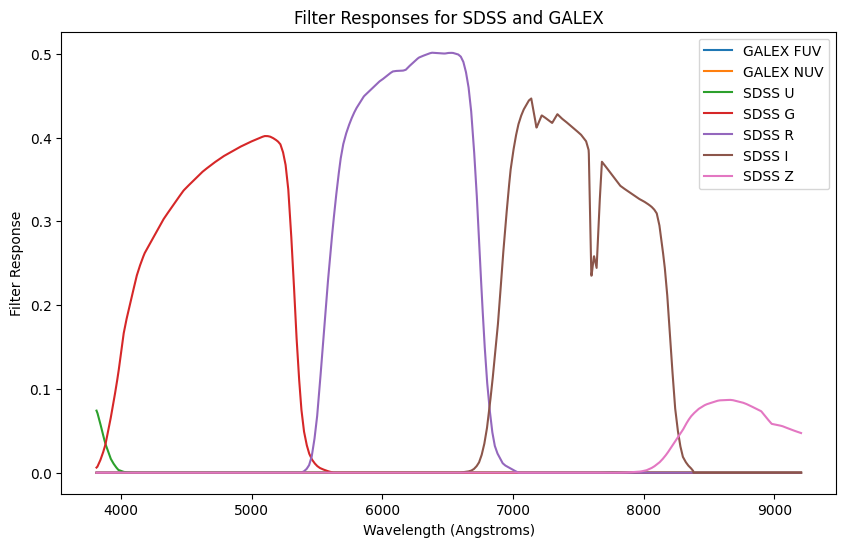

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(lam, GALEX_FUV(lam), label='GALEX FUV')
plt.plot(lam, GALEX_NUV(lam), label='GALEX NUV')
plt.plot(lam, SDSS_U(lam), label='SDSS U')
plt.plot(lam, SDSS_G(lam), label='SDSS G')
plt.plot(lam, SDSS_R(lam), label='SDSS R')
plt.plot(lam, SDSS_I(lam), label='SDSS I')
plt.plot(lam, SDSS_Z(lam), label='SDSS Z')

# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Filter Response')
plt.title('Filter Responses for SDSS and GALEX')
plt.legend()


In [9]:
from pyphot import unit
import pyphot

w,f,e=get_spectrum_from_dja(row[0],redshift=True)

wavelength  = w.value *(1+0.05) * unit['AA']
flux = f.value * unit['erg/s/cm**2/AA']

lib = pyphot.get_library()
f_ = lib['GALEX_FUV']
fr = lib['SDSS_r']
print(f_.get_flux(wavelength, flux).value
)

mag1 = -2.5 * np.log10(f_.get_flux(wavelength, flux).value) - f_.AB_zero_mag
mag2 = -2.5 * np.log10(fr.get_flux(wavelength, flux).value) - fr.AB_zero_mag


AttributeError: 'Column' object has no attribute 'to_value'

In [501]:
wavelength

<Quantity([ 931.27537571  936.43617745  941.68156688  947.01389047  952.43507246
  957.94789329  963.55429841  969.25717495  975.05889207  980.9620071
  986.96959073  993.08414437  999.30882991 1005.64674873 1012.10078208
 1018.67446195 1025.37120754 1032.19431268 1039.14744035 1046.23462832
 1053.4596168  1060.82631555 1068.33897045 1076.00216113 1083.8202918
 1091.79795339 1099.93992836 1108.25119543 1116.73708022 1125.40303743
 1134.25461363 1143.29756417 1152.53785991 1161.98169129 1171.63546906
 1181.50582825 1191.5996327  1201.92397353 1212.48617248 1223.29378693
 1234.35469894 1245.6770905  1257.26924639 1269.13968078 1281.29713467
 1293.75079418 1306.50999334 1319.58414862 1332.98308793 1346.7167995
 1360.79534439 1375.22919273 1390.02871327 1405.20461345 1420.76754415
 1436.72827079 1453.09758591 1469.88621178 1487.10481299 1504.76388035
 1522.87367967 1541.44420537 1560.4850768  1580.00546106 1600.01397407
 1620.5185942  1641.52658194 1663.04417264 1685.07670536 1707.62860958

In [12]:
import numpy as np
import astropy.units as u
from speclite import filters as spf
from astropy.table import Table

def get_spectrum_from_dja(row,redshift=False):
    spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))#.spec

    wave = ((spec.spec['wave']* u.micron).to(u.AA))
    # Convert to FLAM
    flux = (spec.spec['flux'] * spec.spec['to_flam'] * u.uJy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wave))
    err  = (spec.spec['err'] * u.uJy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wave))
    # flux = spec['flux']*spec['to_flam']
    
    if redshift:
        zspec= row['z_best']
        return wave/(1+zspec) , flux, err
    return wave, flux, err
def filter_flux_uncertainty_vec(
    wave_q: u.Quantity,
    filt_names,
    flux_q: u.Quantity,
    flux_sigma_q: u.Quantity,
):
    """
    Synthetic *energy‑integrating* band‑average flux densities and their
    1‑σ uncertainties for one or more filters – **units are preserved
    throughout**.

    See the docstring in the previous message for the full derivation.
    Nothing here strips units; every step uses Astropy's Quantity maths.
    """

    # ------------------------------------------------------------------
    # 0) normalise filt_names to a tuple
    # ------------------------------------------------------------------
    if isinstance(filt_names, (str)):
        filt_names = (filt_names,)
    else:
        filt_names = tuple(filt_names)

    lam        = wave_q           # Å
    f_lambda   = flux_q           # erg s^-1 cm^-2 Å^-1
    sigma_f    = flux_sigma_q

    # grid‑dependent helpers (all keep units)
    dlam       = lam[1:] - lam[:-1]          # Å
    half_dlam  = 0.5 * dlam                 # Å
    half_dlam2 = 0.25 * dlam**2             # Å²

    f_band_list, sig_list, pivot,width = [], [], [], []

    for fname in filt_names:
        filt = spf.load_filter(fname)
        R    = filt(lam)                    # dimensionless response

        R_sum   = R[:-1] + R[1:]
        RF_sum  = R[:-1]*f_lambda[:-1] + R[1:]*f_lambda[1:]
        var_sum = (R[:-1]*sigma_f[:-1])**2 + (R[1:]*sigma_f[1:])**2

        C_lambda = np.sum(half_dlam * RF_sum)        # erg s^-1 cm^-2
        W_lambda = np.sum(half_dlam * R_sum)         # Å
        f_band   = C_lambda #/ W_lambda               # erg s^-1 cm^-2 Å^-1

        var_C    = np.sum(half_dlam2 * var_sum)      # (erg s^-1 cm^-2)²
        sigma_fb = np.sqrt(var_C) #/ W_lambda         # erg s^-1 cm^-2 Å^-1

        width.append(W_lambda)                       # Å
        f_band_list.append(f_band)
        sig_list.append(sigma_fb)
        pivot.append(filt.effective_wavelength)      # Quantity

    return f_band_list, sig_list, pivot, width

def _to_ab_mag_vec(l, flux, filters):
    mag, emag = [], []
    for f in filters:
        filt = pyphot.get_library()[f]
        la=l.value*unit['AA']
        f=flux.value * unit['erg/s/cm**2/AA']
        print(f)
        filt_flux = filt.get_flux(la, f).value
        print(filt_flux)
        mag.append(-2.5 * np.log10(filt_flux) - filt.AB_zero_mag)
        emag.append(np.nan)
    return np.array(mag), np.array(emag)
    

def _to_ab_mag(flux, flux_err, pivot):
    """
    Convert flux to AB magnitudes.
    """
    INV_LN10 = 1 / np.log(10)
    F0_AB = 3631 * u.Jy  # zero‑point
    m_ab, dm_ab = [], []
    for f,e,p in zip(flux, flux_err,pivot):

        f_nu = f.to(u.Jy, equivalencies=u.spectral_density(p))
        if f_nu< 0:
            f_nu = 0 *u.Jy
        s_f_nu = e.to(u.Jy, equivalencies=u.spectral_density(p))
        m_ab.append(-2.5 * np.log10((f_nu / F0_AB)))
        dm_ab.append(2.5 * INV_LN10 * (s_f_nu / f_nu))
        if np.isinf(dm_ab[-1]):
            dm_ab[-1] = np.nan
        if np.isinf(m_ab[-1]):
            m_ab[-1] = np.nan
        

    return m_ab, dm_ab

def LRD_photometry(wave, flux, unc):

    """
    Compute photometry for a given row of the LRD table.
    """

    
    # Compute fluxes and uncertainties in different bands
    phot_flux, phot_sigma, pivot, w = filter_flux_uncertainty_vec(
        wave,
        ['galex-fuv', 'galex-nuv', 'sdss2010-u', 'sdss2010-r', 'sdss2010-g', 'sdss2010-i', 'sdss2010-z'],
        flux,
        unc
    )
 
    # Convert to AB magnitudes
    # ab_mags = [_to_ab_mag(f, s, p) for f, s, p in zip(phot_flux, phot_sigma, pivot)]

    return phot_flux,phot_sigma, pivot, w

def spectra_plot(row,zsdss=0.5, plotter=False):

    _wave, _flux, _unc = get_spectrum_from_dja(row, redshift=True)
    _wave = _wave*(1+zsdss)
    phot_flux,phot_sigma, pivot, w = LRD_photometry(_wave, _flux, _unc)
    mag, mag_unc = _to_ab_mag(phot_flux, phot_sigma, pivot)
    
    if plotter:
            
        # _wave, _flux, _unc = _wave.value[50:-50], _flux.value[50:-50], _unc.value[50:-50]
        fig ,ax = plt.subplots(figsize=(10, 6))
        ax.step(_wave, _flux, label='Spectrum', color='black',where='mid')
        ax.fill_between(_wave, _flux - _unc, _flux + _unc, alpha=0.2, color='gray', label='Uncertainty', step='mid')
        ax.set_xlabel('Wavelength (Angstroms)')
        ax.set_ylabel('Flux (erg/s/cm²/Å)')
        ax.set_title(f"LRD Spectrum for MSA ID {row['srcid']}")

        ax.errorbar(
        [p.value for p in pivot], [pf.value for pf in phot_flux],
        yerr=[ps.value for ps in phot_sigma], xerr=[val.value/2 for val in w],
        fmt='x', label='Synthetic Photometric Fluxes', capsize=3, color='red', markersize=5, elinewidth=1)
        ax.set_yscale('log')

        ax.legend()
        plt.show()
        

    return pivot, w, mag, mag_unc

def table_maker(rows, zsdss=0.5, new_code=False):
    # pivot=[]
    srcid=[]
    magg=[]
    magg_unc=[]
    if new_code:
        for row in rows:
            _wave, _flux, _unc = get_spectrum_from_dja(row, redshift=True)
            _wave = _wave*(1+zsdss)
            mag, mag_unc = _to_ab_mag_vec(
                _wave, _flux, ['GALEX_FUV', 'GALEX_NUV', 'SDSS_u', 'SDSS_r', 'SDSS_g', 'SDSS_i', 'SDSS_z']
            )

            srcid.append(row['srcid'])
            magg.append(mag)
            magg_unc.append(mag_unc)
    else:
        for row in rows:
            _wave, _flux, _unc = get_spectrum_from_dja(row, redshift=True)
            _wave = _wave*(1+zsdss)
            phot_flux,phot_sigma, p , _ = LRD_photometry(_wave, _flux, _unc)
            mag, mag_unc = _to_ab_mag(phot_flux, phot_sigma, p)
            # if p not in pivot:
                # pivot.append(pivot)

            srcid.append(row['srcid'])
            magg.append(mag)
            magg_unc.append(mag_unc)

    # Extract magnitudes for each filter from the lists of lists "magg"
    FUV    = [m[0] for m in magg]
    NUV    = [m[1] for m in magg]
    U      = [m[2] for m in magg]
    R      = [m[3] for m in magg]
    G      = [m[4] for m in magg]
    I      = [m[5] for m in magg]
    Z      = [m[6] for m in magg]

    # Extract uncertainties similarly from "magg_unc"
    FUV_err   = [e[0] for e in magg_unc]
    NUV_err   = [e[1] for e in magg_unc]
    U_err     = [e[2] for e in magg_unc]
    R_err     = [e[3] for e in magg_unc]
    G_err     = [e[4] for e in magg_unc]
    I_err     = [e[5] for e in magg_unc]
    Z_err     = [e[6] for e in magg_unc]

    # Create an Astropy table with the desired columns
    phot_table = Table(
        data=[
            srcid,
            FUV, NUV, U, R, G, I, Z,
            FUV_err, NUV_err, U_err, R_err, G_err, I_err, Z_err
        ],
        names=[
            'srcid', 'FUV', 'NUV', 'U', 'R', 'G', 'I', 'Z',
            'FUV_err', 'NUV_err', 'U_err', 'R_err', 'G_err', 'I_err', 'Z_err'
        ]
    )

    return phot_table




# for i in range(len(row[:])):
#     print(f"Processing row {i+1}/{len(row)}: MSA ID {row[i]['srcid']}")
#     piv,width,magg,magg_unc=spectra_plot(row[i], zsdss=0.2, plotter=True)
#     for p, w, m, mu in zip(piv, width, magg, magg_unc):
#         print(f"Filter: {p:.2f}, Width: {w:.2f}, Mag: {m:.5f} ± {mu:.5f}")

# Create a table with photometry for all rows
phot_table = table_maker(row, zsdss=0.05, new_code=True)
# Save the table to a file
phot_table.write('lrd_photometry_005.csv', format='csv', overwrite=True)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.26625569e-18
  3.11694373e-18  1.99606056e-18 -1.21322747e-18  1.39913527e-18
 -1.89549301e-19 -1.80542703e-18 -4.98748785e-19 -2.34440219e-18
 -1.18987032e-19 -7.49218187e-19 -3.42928743e-19 -5.45171221e-19
 -2.32972688e-19  6.21170423e-19  9.94791432e-19  1.53819799e-18
  6.31537091e-19  8.93897143e-19  6.51287428e-19 -2.48897967e-20
 -1.87808383e-18 -8.48647346e-19 -3.12706847e-19  9.98597749e-19
 -8.26727391e-20  7.02989767e-19  4.57639207e-20 -3.08484932e-19
  3.61346774e-19 -3.56273354e-19 -1.89623056e-19  3.88826696e-19
  5.45636187e-19 -2.70333343e-19  2.07743033e-19 -2.83726454e-20
 -4.91765356e-20  9.35228281e-20  9.27956947e-20 -6.12700492e-20
  1.22561293e-19  3.76501122e-19  1.10938254e-21  3.82916623e-21
  2.04769093e-19  2.23955492e-19  8.09281918e-20  2.70019618e-19
  2.15637639e-20  2.77863629e-19  1.30119508e-19  6.87810791e-20
  1.23894630e-19  2.23554730e-19  9.11543464e-20  1.71083691e-19
  6.99096620e-20  7.13615

In [512]:
phot_table

srcid,FUV,NUV,U,R,G,I,Z,FUV_err,NUV_err,U_err,R_err,G_err,I_err,Z_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1768,29.167886013865694,28.74222742933417,29.76037623484285,29.030477389889995,29.797262362864657,28.968108153396077,28.91354932261734,0.005059174037021446,0.002373774473875576,0.009517155166314432,0.005241726182836027,0.007863131723893479,0.00633284906604381,0.00786791598884662
58018,25.299293260360194,25.292747086324596,26.41704325596495,25.99804858434939,26.65801518108388,26.08263124038144,25.940195773739365,0.0006213721949800054,0.0002405794710385253,0.0010241643859339924,0.0006851937472314129,0.0010083599163084002,0.0008050827903519417,0.0008445279130809514
4820,25.12458004589988,26.119659690575517,27.12382238686764,26.667203345701473,27.336487577171763,26.9821538234622,26.886805541951535,0.0027621333544371974,0.001037279628202486,0.003456006530537673,0.00235861539520868,0.003456274671061725,0.0036672512106577185,0.003910010257865162
13704,28.221909110558872,28.111473197375535,29.328501069112004,29.22353068136692,29.69080896227997,29.848193349635203,29.610457649245898,0.0008839404668756819,0.0006408628883392523,0.0027266787127637714,0.002345663115466353,0.002670772885936577,0.0056381031064798295,0.019584225537894736
73488,25.411069027260403,26.380306618005452,27.27280046160176,27.103130742530258,27.67125542973954,27.31064724353264,27.095188489600165,0.0004127239366721099,0.00047676199685051253,0.0015673296734741472,0.0013543607035883644,0.0018329749957433038,0.001750393045821767,0.0017285641320940537
27830,26.33350660748873,26.1201983839321,27.266456987075195,26.946433035739542,27.85419616683654,27.207318095032804,27.054912162435087,0.0033297515265271324,0.0009930978986430826,0.003990230951065924,0.003264820988291424,0.006059905077399201,0.00460714558948328,0.004905843262184653
28074,nan,22.48815925521533,23.201629646386053,22.501221948917873,23.28188009326912,22.635979961406072,22.21474390121434,nan,0.00040731206911300005,0.0001392327572388901,0.00012801641439062438,0.00012798798986917844,0.00016866318014817082,0.00016752536373359288
38147,27.592428703997115,27.079626950928663,27.978911528417477,27.821538433196658,28.304407012364216,28.328651335709072,28.07988882090255,0.0025190957730862676,0.0011618130872240117,0.004005550439263253,0.003677085432150807,0.003864719882124371,0.007730889081420512,0.011027339588482704
53501,24.970009307275873,25.838779385650355,26.67173101551723,26.206569206887558,26.937285733550187,26.585930576146936,26.422732967283878,0.0025475676854099273,0.0010569341357765227,0.0032103256238958143,0.0021564078416924197,0.003437869421979578,0.0030181932622101635,0.002896764613599098


In [593]:
New_table

RA,DEC,FUV,NUV,u,g,r,i,z,FUV_err,NUV_err,u_err,g_err,r_err,i_err,z_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
241.42538950394,42.4247163180607,-999.0,23.064697265625,23.5160045623779,23.2408123016357,23.4133644104004,23.7338371276855,22.3544521331787,-999.0,0.350302398204803,0.449160933494568,0.166478529572487,0.260348498821259,0.438567370176315,0.504963040351868
243.438657459027,42.1435994046087,-999.0,22.2001514434814,22.6299419403076,22.0198516845703,21.7189483642578,21.4046974182129,21.5809421539307,-999.0,0.309549957513809,0.28039887547493,0.0606698766350746,0.0655407384037972,0.073869414627552,0.310924291610718
243.21805506043,42.2473136834384,-999.0,23.0936374664307,23.0480041503906,23.2697143554688,23.1656646728516,22.7217922210693,21.4513092041016,-999.0,0.451166927814484,0.323603987693787,0.161420941352844,0.208061739802361,0.219160333275795,0.289545089006424
196.464232280024,51.2947766512283,-999.0,22.8188381195068,24.3937206268311,25.0142707824707,23.9989185333252,22.6491279602051,23.0253448486328,-999.0,0.453427165746689,0.79727691411972,0.474069952964783,0.463894993066788,0.233185514807701,0.608633637428284
207.360579656524,45.1443414242399,-999.0,22.3125114440918,23.4575462341309,23.581958770752,23.2118263244629,23.5173416137695,22.7847728729248,-999.0,0.461439937353134,0.687917053699493,0.18217097222805,0.224426910281181,0.369791269302368,0.523886740207672
191.592388456118,41.007635687874,-999.0,23.147159576416,23.08154296875,22.9000053405762,22.7278003692627,22.5559635162354,22.823148727417,-999.0,0.420455694198608,0.272549122571945,0.100092157721519,0.125193610787392,0.173223450779915,0.429273128509521
215.888729890567,44.4155589735508,-999.0,22.6482467651367,23.393913269043,23.7667217254639,22.7908306121826,23.0590171813965,22.8429107666016,-999.0,0.458954334259033,0.419689029455185,0.201646208763123,0.158471569418907,0.359747141599655,0.514146745204926
220.51461469645,35.8438347199717,-999.0,22.7749729156494,24.7681503295898,23.6435108184814,23.2552051544189,22.7938194274902,22.0300178527832,-999.0,0.480631411075592,0.542995631694794,0.180078953504562,0.178632497787476,0.177506998181343,0.310266315937042
225.036362795328,38.8258387841397,-999.0,22.875358581543,23.068431854248,23.520112991333,22.9049472808838,22.9604568481445,21.843677520752,-999.0,0.479865074157715,0.262983351945877,0.17639297246933,0.150597542524338,0.236957088112831,0.345332533121109


In [618]:
len(colour_truth)

6

In [617]:
new_table = New_table[colour_truth]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 297962 but corresponding boolean dimension is 6

In [11]:
NUV_lrd= phot_table['NUV']
FUV_lrd= phot_table['FUV']
U_lrd = phot_table['U']
R_lrd = phot_table['R']
G_lrd = phot_table['G']
I_lrd = phot_table['I']
Z_lrd = phot_table['Z']

NUV_target = New_table['NUV']
FUV_target = New_table['FUV']
U_target = New_table['u']
R_target = New_table['r']
G_target = New_table['g']
I_target = New_table['i']
Z_target = New_table['z']
def colour_colour_plot(colour1, colour2, label1, colour1_target, colour2_target, label2,xlabel='Colour 1', ylabel='Colour 2'):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(colour1_target, colour2_target, label=label2, color='red', alpha=0.01)
    ax.scatter(colour1, colour2, label=label1, color='blue', alpha=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('Colour-Colour Diagram')
    ax.legend()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    plt.show()

# Example usage of the colour_colour_plot function
colour_colour_plot(G_lrd - R_lrd, U_lrd - G_lrd, 
                   'LRD Photometry', 
                   G_target - R_target, U_target - G_target, 
                   'Target Photometry',
                   xlabel='G - R', ylabel='U - G')



NameError: name 'New_table' is not defined

In [586]:
New_table = Table.read('./MyTable_2_gauravsk.csv')

In [776]:
FUV_R= FUV_lrd - R_lrd
FUV_R_target = FUV_target - R_target
NUV_R= NUV_lrd - R_lrd
NUV_R_target = NUV_target - R_target
U_R= U_lrd - R_lrd
U_R_target = U_target - R_target
G_R= G_lrd - R_lrd
I_R= I_lrd - R_lrd
G_R_target = G_target - R_target
I_R_target = I_target - R_target
Z_R= Z_lrd - R_lrd
Z_R_target = Z_target - R_target

Colour_LRD_list= [ NUV_R, U_R, G_R, I_R, Z_R]
Colour_Target_list= [ NUV_R_target, U_R_target, G_R_target, I_R_target, Z_R_target]

(20, 6)

In [746]:
np.array(Colour_Target_list).T[1]

array([-1.02071895e+03,  4.81203079e-01,  9.10993576e-01,  3.00903320e-01,
       -3.14250946e-01, -1.38006210e-01])

In [744]:
print(np.shape(np.array(Colour_Target_list).T))

(297962, 6)


In [814]:
import numpy as np

def rms_filter_nan_safe(templates, data, thresh=1.0):
    """
    templates: shape (6, 20)
    data: shape (6, 280000)
    Returns: list of boolean arrays, each shape (280000,)
             where True means RMS < thresh, ignoring NaNs
    """
    results = []
    for i in range(len(data)):

        template = templates  # shape (6, 1)

        # Mask valid positions (True where neither is NaN)
        valid_mask = ~np.isnan(template) & ~np.isnan(data[i])  # shape (6, 280000)
        
        # Differences, ignoring NaNs
        diff = np.where(valid_mask, data[i] - template, 0.0)  # fill NaNs with 0 so they don't affect sum
        
        # Count valid entries per column
        counts = np.sum(valid_mask)
        
        # Avoid division by zero

        rms = np.sqrt(np.nansum(diff**2) / counts)

        # Compare to threshold
        mask = (rms < thresh) 

        results.append(mask)
    return results



Truth_values= rms_filter_nan_safe(
    np.array(Colour_LRD_list).T[10], 
    np.array(Colour_Target_list).T[:], 
    thresh=0.3
)

In [815]:
maski= (New_table[Truth_values]['z']<19)
New_table[Truth_values][New_table[Truth_values]['r']<20]

RA,DEC,FUV,NUV,u,g,r,i,z,FUV_err,NUV_err,u_err,g_err,r_err,i_err,z_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
336.087384578172,27.0280143770885,-999.0,22.1476821899414,19.9524536132813,18.9869060516357,18.5334358215332,18.348461151123,18.2156543731689,-999.0,0.389881491661072,0.0367509014904499,0.0114065883681178,0.0120103294029832,1.08582377433777,0.0325246155261993
351.79173537665,7.76848797299171,-999.0,21.8998699188232,19.7066249847412,18.6303253173828,18.157621383667,17.9140720367432,17.787166595459,-999.0,0.292956084012985,0.030248736962676,0.0181031245738268,0.0154583789408207,0.0136899361386895,0.0210773833096027
326.410819857681,23.5253331334685,-999.0,22.1438751220703,20.0996246337891,19.1246433258057,18.7299365997314,18.6163349151611,18.4968280792236,-999.0,0.40945091843605,0.0373093448579311,0.0129085648804903,0.016868457198143,0.0231729485094547,0.0353752970695496
348.207196750398,6.0723346469253,-999.0,21.1978397369385,18.9578914642334,17.9830074310303,17.5751876831055,17.3891372680664,17.2866306304932,-999.0,0.212043106555939,0.0195625256747007,0.0250934157520533,0.0165581442415714,0.0238282326608896,0.0189673099666834
39.2238297496523,47.2891277002816,-999.0,20.2655906677246,18.3701496124268,17.2797756195068,16.7312297821045,16.5239944458008,16.3764095306396,-999.0,0.272110968828201,0.0179253406822681,0.0076376721262931,0.0118728186935186,0.0122868586331606,0.0247989874333143
334.488654290463,26.547360318887,-999.0,22.3363304138184,20.4250621795654,19.3439884185791,18.8858547210693,18.6887092590332,18.5890350341797,-999.0,0.471498727798462,0.0470401458442211,0.0131591632962227,0.0162785872817039,0.0150086237117648,0.0306391268968582
226.677148208231,39.1671328642694,-999.0,22.3070793151855,20.2957382202148,19.2836570739746,18.8926391601563,18.7152214050293,18.6414012908936,-999.0,0.371040850877762,0.037920918315649,0.0159830078482628,0.0133375898003578,0.0261176098138094,0.0380674041807652
353.014697876129,7.92102715335376,-999.0,21.9409217834473,19.8985137939453,18.8588027954102,18.4997291564941,18.3538646697998,18.1796569824219,-999.0,0.434508860111237,0.0328273288905621,0.0152995763346553,0.0145276384428144,0.0186247937381268,0.0259403977543116
331.812291579477,10.2707267988797,-999.0,21.7140827178955,19.7338256835938,18.7866592407227,18.3425674438477,18.2095127105713,18.1146202087402,-999.0,0.281106144189835,0.0329173095524311,0.0143057955428958,0.0160262025892735,0.0296269170939922,0.0294922087341547


In [784]:
np.sum(Truth_values)

10

In [768]:
np.array(Colour_Target_list).T[:2]

array([[-1.02241336e+03, -3.48667145e-01,  1.02640152e-01,
        -1.72552109e-01,  3.20472717e-01, -1.05891228e+00],
       [-1.02071895e+03,  4.81203079e-01,  9.10993576e-01,
         3.00903320e-01, -3.14250946e-01, -1.38006210e-01]])

In [726]:
np.shape(np.array(Colour_LRD_list)[:,1])

(6,)

In [713]:
Target_list[Truth_values[9]]['SDSS_RA'], Target_list[Truth_values[9]]['SDSS_DEC'], Target_list[Truth_values[10]]['plate']


(98411    215.677759
 Name: SDSS_RA, dtype: float64,
 98411    44.472545
 Name: SDSS_DEC, dtype: float64,
 Series([], Name: plate, dtype: int64))

In [690]:
Target_list[Truth_values[11]]['SDSS_DEC']

9245      39.906417
45256      2.424479
48013     41.250015
76045     36.911397
141547    27.589474
168100    43.323619
170558     1.711634
173999    38.820480
183528    13.048624
188661     7.619176
198331    37.803609
227599    41.952521
252519     7.325137
294608    72.092833
Name: SDSS_DEC, dtype: float64

In [694]:
sum(sum(Truth_values))


52

In [637]:
np.shape(Colour_Target_list)

(6, 297962)

In [632]:
np.shape(colour_truth)

(6,)

In [ ]:
c11= [NUV_lrd- R_lrd, NUV_lrd - R_lrd, U_lrd - R_lrd, G_lrd - R_lrd, I_lrd - R_lrd, Z_lrd - R_lrd]
c22= [NUV_target - R_target, NUV_target - R_target, U_target - R_target, G_target - R_target, I_target - R_target, Z_target - R_target]



In [510]:
phot_table

srcid,FUV,NUV,U,R,G,I,Z,FUV_err,NUV_err,U_err,R_err,G_err,I_err,Z_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1768,29.14928791982198,28.842993711003178,29.775056346493745,29.040573538114376,29.82367420075422,28.976589480806094,29.016143276590252,nan,nan,nan,nan,nan,nan,nan
58018,25.304722777123985,25.38588723353291,26.428299768481306,26.00738533688278,26.69084482761425,26.090217198846847,26.019706223929706,nan,nan,nan,nan,nan,nan,nan
4820,25.191682680500087,26.21568064530283,27.144220416309036,26.676490018314066,27.375575782911135,26.98991644125528,26.96996745922632,nan,nan,nan,nan,nan,nan,nan
13704,28.20480761950624,28.21444763761367,29.34055684259101,29.230576883597134,29.737577004320194,29.853959001207894,29.69123899164408,nan,nan,nan,nan,nan,nan,nan
73488,25.425011464323333,26.474233161395237,27.286170756875027,27.11134169761905,27.710022187553704,27.315793790670266,27.202958003525968,nan,nan,nan,nan,nan,nan,nan
27830,26.34992979498533,26.216468604394695,27.25434394199544,26.951339590076298,27.898010869282714,27.213203756906264,27.153435470707127,nan,nan,nan,nan,nan,nan,nan
28074,inf,22.57073686443314,23.218444765360363,22.507809729008553,23.30755314901554,22.630013885535146,22.30316401147034,nan,nan,nan,nan,nan,nan,nan
38147,27.56665067280867,27.171594551547575,27.987821051432046,27.82944937442665,28.34972004723845,28.331933641192858,28.199395089189476,nan,nan,nan,nan,nan,nan,nan
53501,25.006676565727396,25.921000144202974,26.689009707460432,26.212769809571906,26.96721556759335,26.59181995231003,26.536078554270258,nan,nan,nan,nan,nan,nan,nan


In [474]:
phot_table[0]['FUV']-  phot_table[0]['R']


-0.7250475058292736

NameError: name 'pivot' is not defined

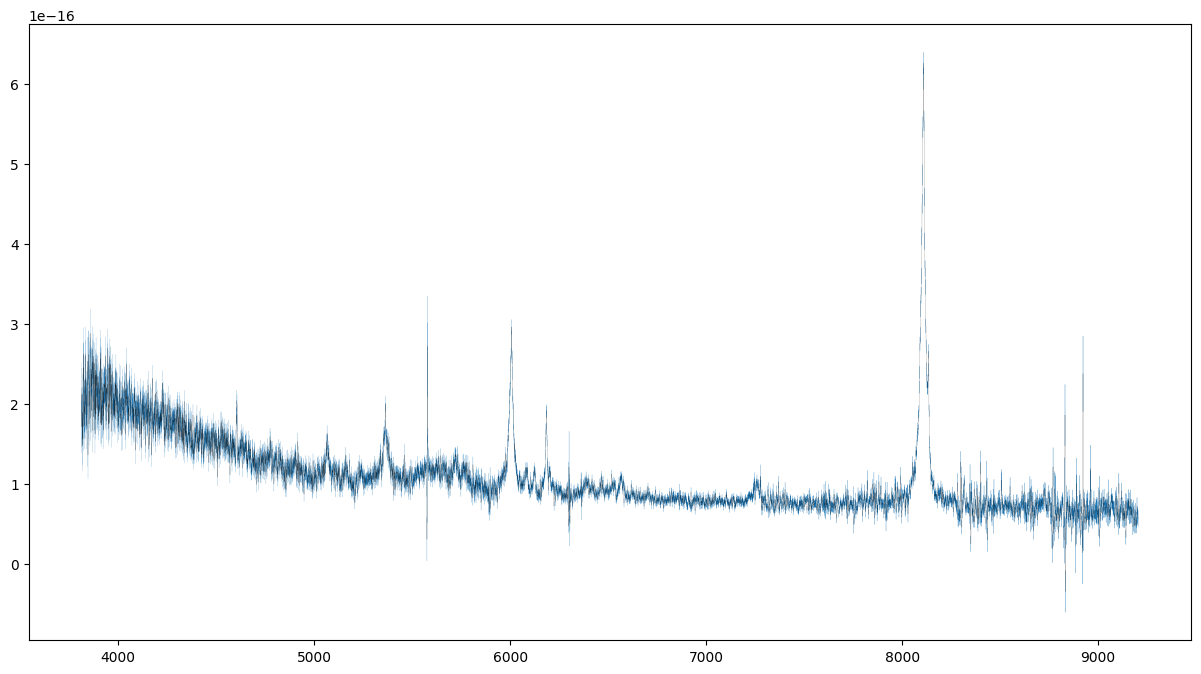

In [440]:
# plt.plot(lam, flux, label='Flux')
fig, ax = plt.subplots(figsize=(15, 8))
ax.fill_between(lam.value, (flux - unc).value, (flux + unc).value, alpha=1, step='mid', label='Uncertainty')
ax.step(lam, flux, label='Flux', where='mid', color='black', linewidth=0.1)
ax.errorbar(
    [p.value for p in pivot], [pf.value for pf in phot_flux],
    yerr=[ps.value for ps in phot_sigma], xerr=[val.value/2 for val in w],
    fmt='x', label='Synthetic Photometric Fluxes', capsize=3, color='red', markersize=5, elinewidth=1
)
ax.legend()
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux Density (erg / (cm² s Å))')

# plt.yscale('log')

### Getting the spectra of the chosen Low$z$ spectra

In [1]:
import sys
import pandas as pd
import numpy as np
from speclite import filters
from astropy import units as u

from matplotlib import pyplot as plt
from astropy.io import fits
import eazy.utils
from grizli import utils
import os
from astropy.utils.data import download_file
import msaexp.spectrum
from astropy.table import Table

if "../" not in sys.path:
	sys.path.append("../")
from Fetching_SDSS_spec import SDSSFetcher

In [204]:
%pip install pandas 

Note: you may need to restart the kernel to use updated packages.


In [2]:

SDSSFetcher = SDSSFetcher(outdir='../spectra_v2_BLSy1',data_release=19)

In [3]:
Header   = fits.open('../seyfert-catalog-v1.fits')['NLSy1'].header
NLSY1_cat= fits.open('../seyfert-catalog-v1.fits')['NLSy1'].data
BLSY1_cat= fits.open('../seyfert-catalog-v1.fits')['BLSy1'].data
# low_cat= pd.read_csv('/Users/gauravsenthilkumar/repositories/Little-Red-Dots/LRDtargets_nospec.csv')

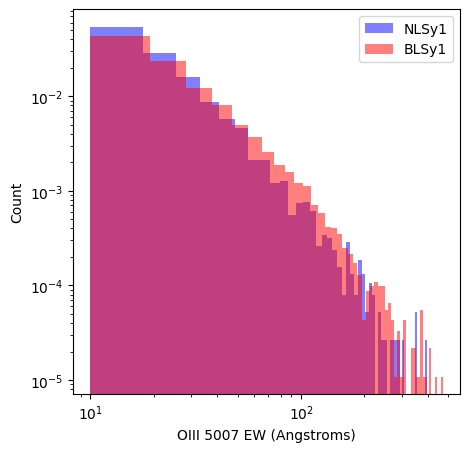

In [4]:
cat_nlsy1 = NLSY1_cat
mask_nlsy1 = (cat_nlsy1['NA_OIII_5007_EW'] > 10) & (cat_nlsy1['NA_H_ALPHA_EW_ERR']!=-999)

cat_blsy1= BLSY1_cat
mask_blsy1 = (cat_blsy1['NA_OIII_5007_EW'] > 10) & (cat_blsy1['NA_H_ALPHA_EW_ERR']!=-999)

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(
    cat_nlsy1['NA_OIII_5007_EW'][mask_nlsy1],
    bins=50, alpha=0.5, label='NLSy1', color='blue', density=True
)
ax.hist(
    cat_blsy1['NA_OIII_5007_EW'][mask_blsy1],
    bins=50, alpha=0.5, label='BLSy1', color='red', density=True
)
ax.set_xlabel('OIII 5007 EW (Angstroms)')
ax.set_ylabel('Count')

ax.legend()
ax.loglog()
plt.show()

In [9]:
ID= [ str(plate) + '-' + str(mjd) + '-' + str(fiberID) for _, plate, mjd, fiberID in cat_blsy1[mask_blsy1]['P-M-F'].split('-')]
SDSSFetcher.fetch_spectra(ID, save=True)

Fetching SDSS spectra:   0%|          | 0/9993 [00:00<?, ?it/s]

✅  Saved ../spectra_v2_BLSy1/spec-11546-58488-0936.fits
✅  Saved ../spectra_v2_BLSy1/spec-11546-58488-0928.fits
✅  Saved ../spectra_v2_BLSy1/spec-9403-58018-0485.fits
✅  Saved ../spectra_v2_BLSy1/spec-8740-57367-0310.fits
✅  Saved ../spectra_v2_BLSy1/spec-9439-58015-0483.fits
✅  Saved ../spectra_v2_BLSy1/spec-7895-57659-0898.fits
✅  Saved ../spectra_v2_BLSy1/spec-7848-56959-0942.fits
✅  Saved ../spectra_v2_BLSy1/spec-7666-57339-0890.fits
✅  Saved ../spectra_v2_BLSy1/spec-7666-57339-0865.fits
✅  Saved ../spectra_v2_BLSy1/spec-0650-52143-0494.fits
✅  Saved ../spectra_v2_BLSy1/spec-11279-58449-0943.fits
✅  Saved ../spectra_v2_BLSy1/spec-0650-52143-0166.fits
✅  Saved ../spectra_v2_BLSy1/spec-4216-55477-0224.fits
✅  Saved ../spectra_v2_BLSy1/spec-4216-55477-0786.fits
✅  Saved ../spectra_v2_BLSy1/spec-7665-57328-0612.fits
✅  Saved ../spectra_v2_BLSy1/spec-11277-58450-0272.fits
✅  Saved ../spectra_v2_BLSy1/spec-8740-57367-0264.fits
✅  Saved ../spectra_v2_BLSy1/spec-7596-56945-0902.fits
✅  Sav

: 

In [254]:
fits_text.info()


Filename: /Users/gauravsenthilkumar/repositories/Little-Red-Dots/Base Code/LRD_spectra_LowZ/spec-2524-54568-0182.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     147   ()      
  1  COADD         1 BinTableHDU     26   3829R x 8C   ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   ['J', 'J', 'J', '13A', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'J', 'J', 'E', 'E']   
  4  B1-00051873-0005

In [314]:
fits_text[0].header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
BOSSVER = '2       '           / ICC version                                    
MJD     =                55352 / APO fMJD day at start of exposure              
MJDLIST = '55351 55352'        /                                                
RA      =           249.698929 / RA of telescope boresight (deg)                
DEC     =            12.000622 / Dec of telescope boresight (deg)               
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '        

In [587]:
Target_list=pd.read_csv('MyTable_2_gauravsk.csv')

2025-08-15 02:35:47,155 - stpipe - WARNING - /var/folders/74/__d4fvn923b5nsfrydw7vf4m0000gn/T/ipykernel_8835/1538401765.py:1: DtypeWarning: Columns (93,197,198,200) have mixed types. Specify dtype option on import or set low_memory=False.
  Target_list=pd.read_csv('MyTable_2_gauravsk.csv')



In [589]:
Ra= Target_list['SDSS_RA']
Dec= Target_list['SDSS_DEC']

FUV_mag= Target_list['fuv_mag']
NUV_mag= Target_list['nuv_mag']

FUV_mag_err= Target_list['fuv_magerr']
NUV_mag_err= Target_list['nuv_magerr']

U_mag= Target_list['psfMag_u']
U_mag_err= Target_list['psfMagErr_u']
G_mag= Target_list['psfMag_g']
G_mag_err= Target_list['psfMagErr_g']
R_mag= Target_list['psfMag_r']
R_mag_err= Target_list['psfMagErr_r']
I_mag= Target_list['psfMag_i']
I_mag_err= Target_list['psfMagErr_i']
Z_mag= Target_list['psfMag_z']
Z_mag_err= Target_list['psfMagErr_z']


In [590]:
New_table = Table(
    data=[
        Ra, Dec, FUV_mag, NUV_mag, U_mag, G_mag, R_mag, I_mag, Z_mag,
        FUV_mag_err, NUV_mag_err, U_mag_err, G_mag_err, R_mag_err, I_mag_err, Z_mag_err
    ],
    names=[
        'RA', 'DEC', 'FUV', 'NUV', 'u', 'g', 'r', 'i', 'z',
        'FUV_err', 'NUV_err', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err'
    ]
)

In [591]:
New_table.write('LRD_Targets.csv', format='csv', overwrite=True)

In [384]:
Target_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   e_bv         2 non-null      float64
 1   fuv_mag      2 non-null      float64
 2   fuv_magerr   2 non-null      float64
 3   nuv_mag      2 non-null      float64
 4   nuv_magerr   2 non-null      float64
 5   SDSS_RA      2 non-null      float64
 6   SDSS_DEC     2 non-null      float64
 7   psfMag_u     2 non-null      float64
 8   psfMag_g     2 non-null      float64
 9   psfMag_r     2 non-null      float64
 10  psfMag_i     2 non-null      float64
 11  psfMag_z     2 non-null      float64
 12  psfMagErr_u  2 non-null      float64
 13  psfMagErr_g  2 non-null      float64
 14  psfMagErr_r  2 non-null      float64
 15  psfMagErr_i  2 non-null      float64
 16  psfMagErr_z  2 non-null      float64
 17  psffwhm_g    2 non-null      float64
 18  psffwhm_r    2 non-null      float64
 19  specObj_ID  

In [386]:
New_table

RA,DEC,FUV,NUV,u,g,r,i,z,FUV_err,NUV_err,u_err,g_err,r_err,i_err,z_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
260.55903013284507,29.38462850026266,21.83094,21.46661,22.406488,22.375761,21.604599,21.466669,21.549208,0.43849176,0.36554569,0.19528686,0.085248597,0.069648318,0.08722508,0.28376663
244.25499071017492,21.37045645068466,21.502275,21.245754,22.171568,22.528965,21.920053,22.45929,22.138956,0.40707192,0.2308405,0.28340691,0.24444245,0.25518405,0.5234127,0.53337121


redshift: 0.12746397


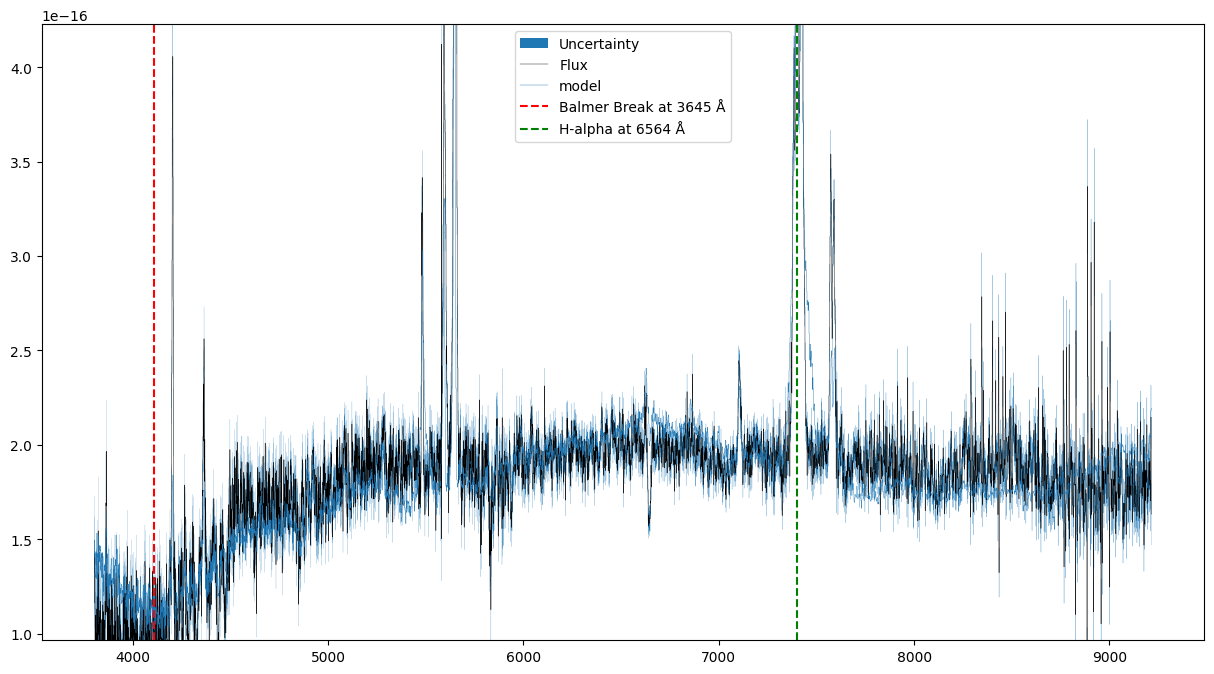

In [839]:
fits_text=fits.open(Potential_LRDs[1])




                    
def SDSS_plotter(object):
    balmer_break= 3645 
    halpha = 6564 
    z=object['SPZLINE'].data['LINEZ']
    postive_z = z > 0
    z= np.mean(z[postive_z])
    obj = object['COADD'].data
    lam=10**obj['loglam'] * u.AA #/ (1+z)
    flux= obj['flux'] * u.erg / (u.cm**2 * u.s * u.AA) *  1e-17

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.fill_between(lam.value, (flux - obj['ivar']**-0.5 * u.erg / (u.cm**2 * u.s * u.AA) *  1e-17).value, 
                     (flux + obj['ivar']**-0.5 * u.erg / (u.cm**2 * u.s * u.AA) *  1e-17).value, 
                     alpha=1, step='mid', label='Uncertainty')
    ax.step(lam, flux, where='mid', label='Flux', color='black', linewidth=0.3,alpha=1)
    flux= obj['model'] * u.erg / (u.cm**2 * u.s * u.AA) *  1e-17
    ax.step(lam, flux, where='mid', label='model',  linewidth=0.3)
    print('redshift:', z)

    ax.axvline(balmer_break*(1+z), color='red', linestyle='--', label='Balmer Break at 3645 Å')
    ax.axvline(halpha*(1+z), color='green', linestyle='--', label='H-alpha at 6564 Å')
    ax.legend()
    ax.set_ylim(0.99 * np.nanmin(flux.value),0.7 * np.nanmax(flux.value))
    # ax.set_yscale('log')
    # ax.set_xlim(7800,8300)





    
    plt.show()
                    
                    
SDSS_plotter(fits_text)

In [12]:
from astropy.table import Table

In [ ]:
((fits_text['SPZLINE']))

array([[1.5536956, 1.5731416, 1.5116569, 1.277062 , 1.3646139]],
      dtype='>f4')

In [7]:
line(fits_text,Line_name)

NameError: name 'line' is not defined

In [106]:
interestedline_idx= [7,18,-5]


In [108]:
Line_name= ['H_alpha', '[O_II] 3727', '[O_III] 5007']

1.5536956

In [193]:
fits_text['SPZLINE'].data[fits_text['SPZLINE'].data['LINENAME']== 'H_alpha']





FITS_rec([(625, 52145, 331, 'H_alpha', 6564.61389433, 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0, 0, 0., -1.)],
         dtype=(numpy.record, [('PLATE', '>i4'), ('MJD', '>i4'), ('FIBERID', '>i4'), ('LINENAME', 'S13'), ('LINEWAVE', '>f8'), ('LINEZ', '>f4'), ('LINEZ_ERR', '>f4'), ('LINESIGMA', '>f4'), ('LINESIGMA_ERR', '>f4'), ('LINEAREA', '>f4'), ('LINEAREA_ERR', '>f4'), ('LINEEW', '>f4'), ('LINEEW_ERR', '>f4'), ('LINECONTLEVEL', '>f4'), ('LINECONTLEVEL_ERR', '>f4'), ('LINENPIXLEFT', '>i4'), ('LINENPIXRIGHT', '>i4'), ('LINEDOF', '>f4'), ('LINECHI2', '>f4')]))

In [194]:
def line(fits_file,Line_name):
    return Table(fits_file['SPZLINE'].data[fits_file['SPZLINE'].data['LINENAME']== Line_name])
def petrosian(fits_file):
    return fits_file['SPALL'].data['PETROTHETA'][0][1],fits_file['SPALL'].data['PETROTHETA'][0][2]
def check_petrosian(fits_file):
    if 'SPALL' in fits_file:
        return False
    return True

In [335]:
def exist(data):
    # print(data.info())
    # if check_petrosian(data):
    #     return False
    H_alpha = line(data,'H_alpha')
    OII = line(data, '[O_II] 3727')
    OIII = line(data, '[O_III] 5007')

    # print('OII:', OII)
    # print('OIII:', OIII)



       
    # radius_g, radius_r = petrosian(data)



    # Access the first row of each line
    ha = H_alpha[:]
    oii = OII[:]
    oiii = OIII[:]

    # if radius_g > 3 or radius_r > 3:
    #     return False
    # z=data['SPZLINE'].data['LINEZ']
    # postive_z = z > 0
    # z= np.mean(z[postive_z])

    # if z>1:
        
    #     return False



    if oii['LINEAREA_ERR'] < 0 or oiii['LINEAREA_ERR'] < 0:
        return False
    if ha['LINECONTLEVEL_ERR'] < 0 or oii['LINECONTLEVEL_ERR'] < 0 or oiii['LINECONTLEVEL_ERR'] < 0:
        return False
    if oiii['LINEEW_ERR'] < 0:
        return False

    O32 = oiii['LINEAREA'] / oii['LINEAREA']
    if O32 < 10:
        return False
    O32_cont= oiii['LINECONTLEVEL'] / oii['LINECONTLEVEL']
    # if O32_cont < 1:
    #     return False
    fHacont = ha['LINECONTLEVEL'] / oiii['LINECONTLEVEL']
    if fHacont < 1:
        return False


    if oiii['LINEEW'] < 10:
        
        return False

    return True

In [835]:
from tqdm.notebook import tqdm


folder_path = '/Users/gauravsenthilkumar/repositories/Little-Red-Dots/Base Code/LRD_spectra_LowZ_v3'
fits_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.fits')]

spzline_data_list = []
del Potential_LRDs
Potential_LRDs = []
for file in tqdm(fits_files, desc="Scanning FITS files for LRDs"):
    with fits.open(file) as hdul:
        if exist(hdul):
            Potential_LRDs.append(file)
        else:
            continue
            
print(len(Potential_LRDs), "Potential LRDs found.")

Scanning FITS files for LRDs:   0%|          | 0/755 [00:00<?, ?it/s]

2 Potential LRDs found.


In [153]:
fits_text

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x190f47370>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x18febf400>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x18febfb20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190b2c250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190b2cd90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190b2cfd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190b2c400>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190dea650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190de9ff0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190f44c70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190fe09d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190fe0b80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x190fe2fb0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x18ff5f820>]

In [840]:
fits_text[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4589163808.62 / 1st row - Number of seconds since Nov 17 1858  
RA      =            211.54569 / 1st row - Right ascension of telescope boresigh
DEC     =            44.402900 / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '07:28:56.01'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                53115 / MJD of observation                             
MJDLIST = '53115   '        